# Import libraries

In [1]:
import os
import copy
import matplotlib
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from lmfit import  Model, Parameters

# Functions

In [3]:
def plot_style():
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='k')

    plt.rcParams['xtick.direction'] = 'in' 
    plt.rcParams['ytick.direction'] = 'in' 
    plt.rcParams['xtick.top'] = True 
    plt.rcParams['ytick.right'] = True  
    plt.rc('font', size='20')  
    
    params = {'legend.fontsize': '20',
         'figure.figsize': (10,6),
         'axes.labelsize': '26',
         'axes.titlesize':'26',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'xtick.major.pad':'16',
         'ytick.major.pad':'16'}
    
    pylab.rcParams.update(params)

In [4]:
def lq(x, alpha, beta):
    return (-alpha*x-beta*x**2)

# Open data

In [5]:
fname = os.path.join('tmp','rawdata.h5')
df = pd.read_hdf(fname, 'data')

# Fit

In [6]:
lqmodel = Model(lq, nanpolicy='propagate')
params = Parameters()
params.add('alpha', value=0.0002, min=0)
params.add('beta', value=0.0001, min=0, max=1e8)

In [7]:
for name, group in df.groupby('article'):
    for energy, data in group.groupby('energy'):
        result = lqmodel.fit(params=params, 
                             data=np.log(data.sf), 
                             x=data.dose,
                             weights=np.fabs(1/(np.log(data.sf_err_up)-np.log(data.sf_err_down))))
        
        df.loc[(name,energy),'alpha_fit'] = result.values['alpha']
        df.loc[(name,energy),'alpha_fit_err'] = result.params['alpha'].stderr
        df.loc[(name,energy),'beta_fit_err'] = result.params['beta'].stderr
        df.loc[(name,energy),'residuals']=(result.residual)
        df.loc[(name,energy),'residuals_limit']=(result.residual.std())
        df.loc[(name,energy),'covar_fit']=result.covar[1][0]
        df.loc[(name,energy),'fit_results']=copy.deepcopy(result)
        
        if (result.values['beta']<result.params['beta'].stderr).any() & (result.values['beta']<0.01).any():
            df.loc[(name,energy),'beta_fit'] = 0.0
        else:
            df.loc[(name,energy),'beta_fit'] = result.values['beta']

C:\Users\Kinga Jelen\Anaconda\envs\pytrip\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [8]:
df.sort_index(inplace=True)

In [9]:
for name, group in df.groupby('article'):
        for energy, data in group.groupby('energy'):
            if energy==0:
                alfa_ref = data["alpha_fit"].max()
                beta_ref = data["beta_fit"].max()
                alfa_ref_art = data["alpha"].max()
                beta_ref_art = data["beta"].max()

                df.loc[(name,energy),'a(fit)/a_ref(fit)'] = 0.0
                df.loc[(name,energy),'b(fit)/b_ref(fit)'] = 0.0
                df.loc[(name,energy),'a/a_ref'] = 0.0
                df.loc[(name,energy),'b/b_ref'] = 0.0
            else :
                df.loc[(name,energy),'a(fit)/a_ref(fit)'] = (data["alpha_fit"])/alfa_ref 
                df.loc[(name,energy),'b(fit)/b_ref(fit)'] = (data["beta_fit"])/beta_ref 
                df.loc[(name,energy),'a/a_ref'] = (data["alpha"])/alfa_ref_art 
                df.loc[(name,energy),'b/b_ref'] = (data["beta"])/beta_ref_art 
            df.loc[(name,energy),'a(fit)/b(fit)'] = (data["alpha_fit"])/(data["beta_fit"])

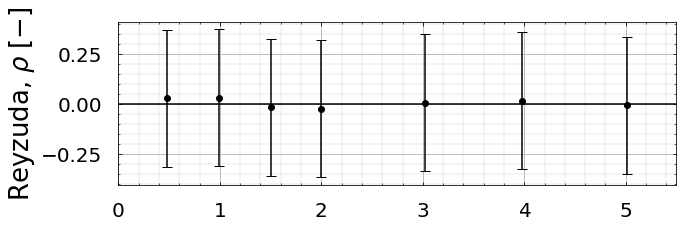

In [57]:
data = df.loc['10'].loc[5010]

plt.errorbar(data.dose,  
             data.sf - np.exp(data.fit_results.iloc[0].best_fit),  
             yerr=(data.residuals_limit),  
             fmt='o', capsize=5,color='k')

plt.axhline(0., color='k')

plot_style()
plt.rcParams["figure.figsize"] = (10,3)

plt.ylabel("Reyzuda, "+ r'$\rho \;[-]$')
plt.xlabel("")

plt.xlim(0.,5.5)

tmp=pd.DataFrame(list(zip(data.dose,
                          data.sf - np.exp(data.fit_results.iloc[0].best_fit),
                          data.residuals_limit)),
                          columns=['dose','residuals', 'residuals_err'])
tmp.to_csv("results/figure_5_1a")
plt.savefig(fname="results/figure_5_1a",dpi= 700)

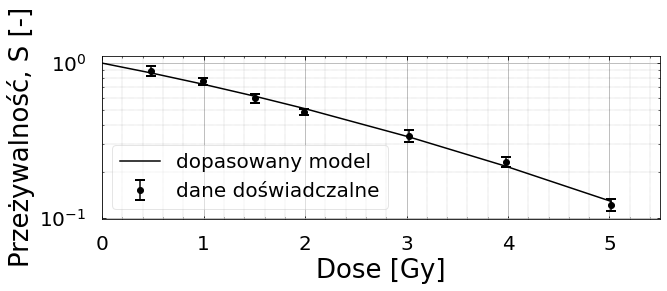

In [58]:
data = df.loc['10'].loc[5010]

plt.scatter(data.dose, 
            data.sf,
            s=6, c="k")

plt.errorbar(data.dose, 
             data.sf, 
             yerr=data.sf_error,
             fmt='o', color='k', capthick=2,capsize=5, 
             label = "dane doświadczalne")

plt.plot(np.append(0,data.dose), 
         np.append(1,np.exp(data.fit_results.iloc[0].best_fit)), 
         c='k', 
         label="dopasowany model")

plot_style()

plt.xlim(0.,5.5)
plt.ylabel("Przeżywalność, S [-]")
plt.xlabel("Dose [Gy]")

plt.yscale('log')

leg = plt.legend(loc='best', ncol=1)         
leg.get_frame().set_alpha(0.5)

tmp=pd.DataFrame(list(zip(data.dose,
                          data.sf)),
                          columns=['dose','sf'])
tmp.to_csv("results/figure_5_1b")
plt.savefig(fname="results/figure_5_1b",dpi= 700)

# Definition of RBE

In [12]:
a1 = df.loc["10"].loc[0].fit_results[0].params['alpha'].value
b1 = df.loc["10"].loc[0].fit_results[0].params['beta'].value

a2 = df.loc["10"].loc[3200].fit_results[0].params['alpha'].value
b2 = df.loc["10"].loc[3200].fit_results[0].params['beta'].value

In [13]:
dose1 = np.append(0 , df.loc["10"].loc[0].dose.values)
dose2 = np.append(0 , df.loc["10"].loc[3200].dose.values)

sf1 = np.exp(-a1*dose1-b1*dose1**2)
sf2 = np.exp(-a2*dose2-b2*dose2**2)

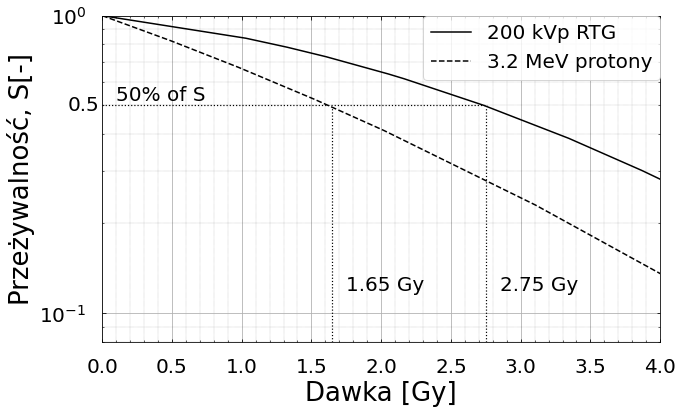

In [14]:
plt.plot(dose1, 
         sf1, 
         "k",
         label="200 kVp RTG",
         )
plt.plot(dose2,
         sf2,
         "k--",
         label = "3.2 MeV protony")

plt.axhline(0.5,c="k" ,xmax=0.69,ls=':',lw=1.2)
plt.text(0.1, .52, '50% of S',c='k')

plt.text(-0.25, .48, '0.5')

plt.axvline(2.75,c="k", ymax=0.72,ls=':',lw=1.2)
plt.text(2.85, .1, '2.75 Gy\n',c='k')

plt.axvline(1.65,c="k", ymax=0.72,ls=':',lw=1.2)
plt.text(1.75, .1, '1.65 Gy\n',c='k')

plot_style()

plt.xlabel("Dawka [Gy]")
plt.ylabel("Przeżywalność, S[-]")

plt.yscale('log')
plt.xlim(0,4)
plt.ylim(0.08,1)

plt.legend( loc='upper right', ncol=1,  borderaxespad=0.)

tmp=pd.DataFrame(list(zip(dose2,sf2,
                          dose1,sf1)),
                          columns=['dose_proton','sf_proton','dose_ref','sf_ref'])
tmp.to_csv("results/figure_2_1")

plt.savefig(fname="results/figure_2_1",dpi= 700)

# Compare alfa & beta

In [15]:
i=0
for name, group in df.groupby('article'):
    #print(name)
    for energy, data in group.groupby('energy'):
        i=i+1
        if data['beta_fit'].any() == 0.:
            df.loc[(name,energy),'div_b_bfit'] = 0.
            df.loc[(name,energy),'err_b_bfit'] = 0.
        else:
            df.loc[(name,energy),'div_b_bfit'] = data['beta']/data['beta_fit']

        df.loc[(name,energy),'err_b_bfit'] = (data["beta_err"]/data["beta_fit"])-(data["beta"]*data["beta_fit_err"])/(data["beta_fit"]**2)
        
        df.loc[(name,energy),'div_a_afit'] = data['alpha']/data['alpha_fit']
        df.loc[(name,energy),'err_a_afit'] = (data["alpha_err"]/data["alpha_fit"])-(data["alpha"]*data["alpha_fit_err"])/(data["alpha_fit"]**2)
        df.loc[(name,energy),'exp_no'] = i

In [16]:
df2=df.reset_index().drop_duplicates(subset=['article','energy'])

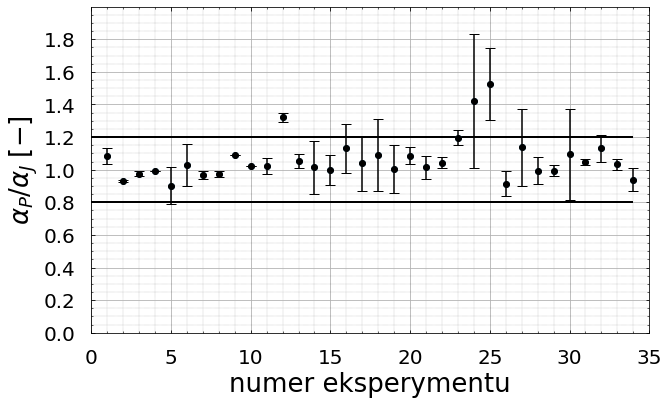

In [17]:
plt.plot(df2.exp_no,
         df2.div_a_afit,
         'o', alpha = 0.6)
plt.errorbar(df2.exp_no,
             df2.div_a_afit,
             yerr=df2.err_a_afit,
             zorder=2, fmt='o',
             capsize=5,color='k')

plt.hlines(y=1.2, xmin=0, xmax=len(df2.exp_no.values), linewidth=2, color='k')
plt.hlines(y=0.8, xmin=0, xmax=len(df2.exp_no.values), linewidth=2, color='k')

plot_style()

plt.yticks(np.arange(0,2,0.2))
plt.ylim(0,2)
plt.xlim(0,35)

plt.ylabel(r'$\alpha_{P}/ \alpha_{J} \;[-]$')
plt.xlabel("numer eksperymentu")

tmp=pd.DataFrame(list(zip(df2.exp_no,
                          df2.div_a_afit,
                          df2.err_a_afit)),
                          columns=['exp_no','alpha_alpha_ref','alpha_alpha_ref_err'])
tmp.to_csv("results/figure_5_3a")

plt.savefig(fname="results/figure_5_3a",dpi= 700)

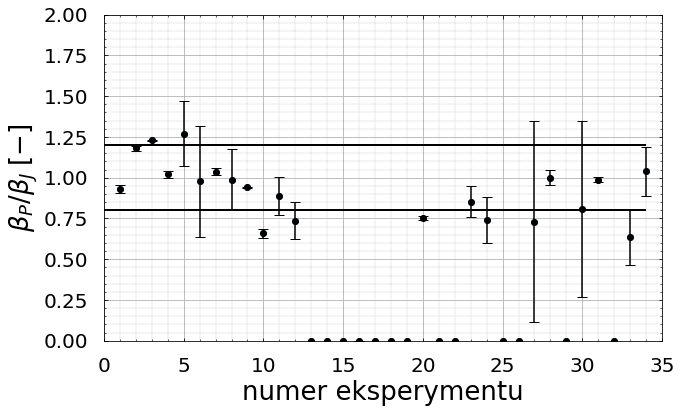

In [18]:
plt.plot(df2.exp_no,
         df2.div_b_bfit,
         'o', alpha = 0.6)
plt.errorbar(df2.exp_no,
             df2.div_b_bfit,
             yerr=df2.err_b_bfit,
             zorder=2, fmt='o',
             capsize=5,color='k')

plt.hlines(y=1.2, xmin=0, xmax=len(df2.exp_no.values), linewidth=2, color='k')
plt.hlines(y=0.8, xmin=0, xmax=len(df2.exp_no.values), linewidth=2, color='k')

plot_style()

plt.ylim(0,2)
plt.xlim(0,35)

plt.ylabel(r'$\beta_{P}/ \beta_{J} \;[-]$')
plt.xlabel("numer eksperymentu")

tmp=pd.DataFrame(list(zip(df2.exp_no,
                          df2.div_b_bfit,
                          df2.err_b_bfit)),
                          columns=['exp_no','beta_beta_ref','beta_beta_ref_err'])
tmp.to_csv("results/figure_5_3b")

plt.savefig(fname="results/figure_5_3b",dpi= 700)

# Save temporary files

In [45]:
df2 = df[["alpha","beta","beta_err","alpha_err","alpha_fit","alpha_fit_err","beta_fit","beta_fit_err","sf","sf_error","sf_err_up","sf_err_down","a(fit)/b(fit)","covar_fit",'a(fit)/a_ref(fit)','a/a_ref',"LET"]]

In [46]:
hdf_fname = os.path.join('tmp','fitted_data.h5')
df2.to_hdf(hdf_fname, 'data', format='table')